下面是一个简单的教程，我们将使用scutquant的scutquant、alpha、report和executor模块完成一个从用原始数据构建因子，特征工程和数据清洗，划分数据集，使用模型做信号合成，并根据预测值进行模拟实盘回测的全过程 :)

用到的各模块的主要功能如下:  

* scutquant: 主要负责除了因子构建以外的数据处理，包括数据清洗，数据集划分和pca等等，也提供一些可直接调用的简单的模型（主要是树模型和线性模型）
* alpha: 主要负责与因子相关的数据处理，并批量生成因子（对单因子的精细处理可通过底层的operators模块实现），提供单因子回测函数
* report: 主要负责对计算结果生成报告，无论是因子数据（single_factor_ana）还是分组报告（group_return_ana）还是整个回测的报告
* executor: 根据预测值和策略按datetime（可以是任何频率的数据）执行回测，并返回一个executor对象，其中包含了用户的账户对象user_account，内含回测的全部细节

In [1]:
# 导入需要用到的库
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

样例数据集只有基础的价量数据，以面板数据的形式呈现. 当需要额外数据构建因子时(例如需要构建市场因子Rm), 就需要读取supplemental data. 当补充数据为时序数据时，可以使用join_data函数将其合并到数据集中；当补充数据为各个股票的截面数据时，可以使用join_data_by_code按股票代码将数据合并到数据集中

In [2]:
# 读取数据
df = pd.read_csv("D:/Desktop/csidata.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index(["datetime", "instrument"], inplace=True)
df

open   high    low  close  pre_close  change  pct_chg  \
datetime   instrument                                                           
2006-01-04 000001.SZ    6.13   6.33   6.12   6.28       6.14    0.14   2.2800   
           000002.SZ    4.40   4.67   4.40   4.66       4.31    0.35   8.1200   
           000012.SZ    4.70   4.75   4.55   4.70       4.62    0.08   1.7300   
           000016.SZ    3.52   3.58   3.52   3.57       3.52    0.05   1.4200   
           000021.SZ    7.99   8.40   7.99   8.32       8.00    0.32   4.0000   
...                      ...    ...    ...    ...        ...     ...      ...   
2023-07-27 688363.SH   94.34  96.20  94.00  95.90      94.70    1.20   1.2672   
           688396.SH   55.25  56.25  54.92  55.36      54.92    0.44   0.8012   
           688561.SH   48.96  49.38  48.80  48.83      49.11   -0.28  -0.5701   
           688599.SH   36.40  37.29  36.36  36.39      36.61   -0.22  -0.6009   
           688981.SH   50.01  50.14  49.20  49.39      50.15   -0.76  -1.5155   

                             amount     volume  
datetime   instrument                           
2006-01-04 000001.SZ    96989.00660  154450.68  
           000002.SZ   175187.06570  389310.43  
           000012.SZ    18863.86250   40399.61  
           000016.SZ     5131.87930   14426.65  
           000021.SZ    27657.17080   33526.60  
...                             ...        ...  
2023-07-27 688363.SH   276386.76000   28957.40  
           688396.SH   218456.02400   39268.57  
           688561.SH    76213.86113   15532.40  
           688599.SH   456467.83070  124308.87  
           688981.SH   812613.12370  163390.62  

[1240545 rows x 9 columns]

**关于目标值:** 为了避免数据泄露和其它各种问题，我们构建的目标值应尽量与已知数据无关(即$y_t$无法用已知的数据${X_t, X_{t-1}, ...}$计算得到). 这里我们选择$label = \frac{close_{-2}}{close_{-1}} - 1$, 即T时刻需要预测的目标值是T+2相对于T+1的收益率, 现实意义是在今天(T)作出预测, 并在明天(T+1)以收盘价开仓, 后天(T+2)以收盘价平仓  

**关于因子:** 参考alpha模块中的make_factors()和alpha360(), 前者主要为技术指标, 后者是原始量价数据的滞后项除单位, 目的是让模型在张成的360维空间中自行发掘因子

In [3]:
# 构造目标值
df["label"] = df["pct_chg"].groupby("instrument").shift(-2) / 100
df = df.dropna() 

In [4]:
X = alpha.qlib158(df)
X = pd.concat([X, df[["label"]]], axis=1)
X

open  close   high    low     volume        amount  \
datetime   instrument                                                        
2006-01-04 000001.SZ    6.13   6.28   6.33   6.12  154450.68   96989.00660   
           000002.SZ    4.40   4.66   4.67   4.40  389310.43  175187.06570   
           000012.SZ    4.70   4.70   4.75   4.55   40399.61   18863.86250   
           000016.SZ    3.52   3.57   3.58   3.52   14426.65    5131.87930   
           000021.SZ    7.99   8.32   8.40   7.99   33526.60   27657.17080   
...                      ...    ...    ...    ...        ...           ...   
2023-07-25 688363.SH   94.50  94.00  94.80  93.48   23240.16  218724.75750   
           688396.SH   55.08  55.00  55.08  54.53   23315.78  128021.63980   
           688561.SH   48.99  49.33  49.52  48.73   18971.42   93278.72053   
           688599.SH   35.87  36.39  36.45  35.77  117105.58  423724.03390   
           688981.SH   49.66  49.77  49.80  49.23  179668.83  890948.32340   

                          open1     open2     open3     open4  ...   vsump10  \
datetime   instrument                                          ...             
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN  ...       NaN   
           000002.SZ        NaN       NaN       NaN       NaN  ...       NaN   
           000012.SZ        NaN       NaN       NaN       NaN  ...       NaN   
           000016.SZ        NaN       NaN       NaN       NaN  ...       NaN   
           000021.SZ        NaN       NaN       NaN       NaN  ...       NaN   
...                         ...       ...       ...       ...  ...       ...   
2023-07-25 688363.SH   0.998085  0.962660  0.961277  0.953936  ...  0.151169   
           688396.SH   0.986727  0.979818  0.985455  0.981818  ...  0.014767   
           688561.SH   0.973039  0.970809  0.991689  1.003446  ... -0.097845   
           688599.SH   0.986260  0.989283  1.002748  1.006046  ...  0.060621   
           688981.SH   0.982118  0.984730  0.991159  0.994575  ... -0.022692   

                        vsump20   vsump30   vsump60    vsumn5   vsumn10  \
datetime   instrument                                                     
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN       NaN   
           000002.SZ        NaN       NaN       NaN       NaN       NaN   
           000012.SZ        NaN       NaN       NaN       NaN       NaN   
           000016.SZ        NaN       NaN       NaN       NaN       NaN   
           000021.SZ        NaN       NaN       NaN       NaN       NaN   
...                         ...       ...       ...       ...       ...   
2023-07-25 688363.SH   0.067856 -0.234478 -0.047606 -0.242995 -0.151169   
           688396.SH  -0.099715 -0.278204 -0.085300 -0.033904 -0.014767   
           688561.SH  -0.065561 -0.088517 -0.032193  0.307803  0.097845   
           688599.SH  -0.044404 -0.141937 -0.018149 -0.046496 -0.060621   
           688981.SH  -0.010020 -0.058739 -0.073201  0.429199  0.022692   

                        vsumn20   vsumn30   vsumn60     label  
datetime   instrument                                          
2006-01-04 000001.SZ        NaN       NaN       NaN  0.014200  
           000002.SZ        NaN       NaN       NaN -0.006400  
           000012.SZ        NaN       NaN       NaN  0.000000  
           000016.SZ        NaN       NaN       NaN  0.002700  
           000021.SZ        NaN       NaN       NaN -0.003600  
...                         ...       ...       ...       ...  
2023-07-25 688363.SH  -0.067856  0.234478  0.047606  0.012672  
           688396.SH   0.099715  0.278204  0.085300  0.008012  
           688561.SH   0.065561  0.088517  0.032193 -0.005701  
           688599.SH   0.044404  0.141937  0.018149 -0.006009  
           688981.SH   0.010020  0.058739  0.073201 -0.015155  

[1238773 rows x 155 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1238773 entries, (Timestamp('2006-01-04 00:00:00'), '000001.SZ') to (Timestamp('2023-07-25 00:00:00'), '688981.SH')
Columns: 155 entries, open to label
dtypes: float64(155)
memory usage: 1.4+ GB
None
X_mis= 1.381499169716923
original label:


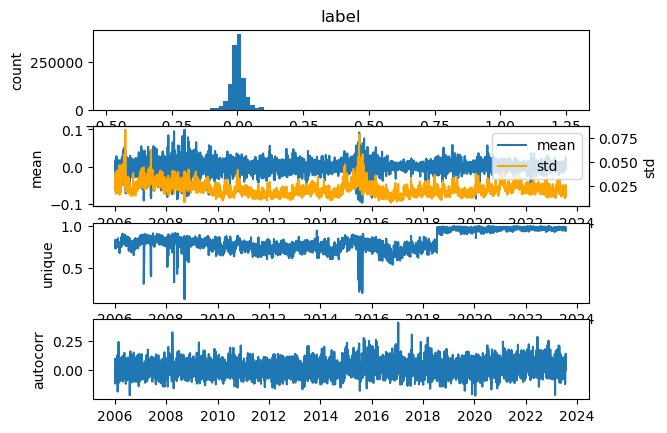

label processed:


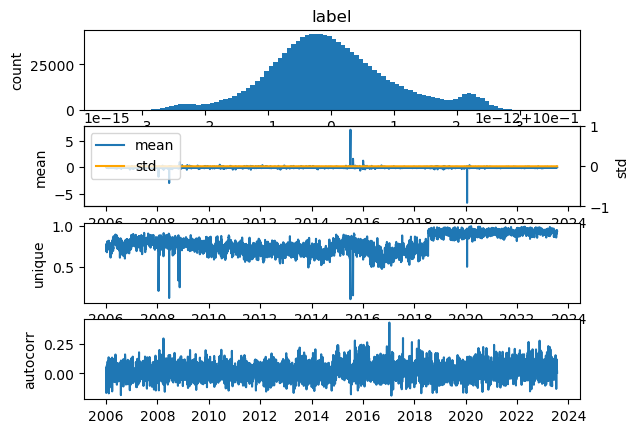

process dataset done
split data done 

all works done 



In [5]:
split_params = {
    "test_start_date": "2018-01-01",
    "split_method": "split_by_date",
    "split_kwargs":{
        "train_end_date": "2015-12-31",
        "valid_end_date": "2017-12-31"
    }
}
# 使用auto_process按照标准流程进行数据处理, 并按split_params拆分出训练集、验证集和测试集
result = q.auto_process(X, "label", split_params=split_params, unique_threshold=0.5)

X_train, y_train, X_valid, y_valid, X_test, y_test = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"], result["X_test"], result["y_test"]

Epoch: 1 loss: 0.9993391375915677 val_loss: 0.9925945419512812 val_ic: 0.06413653606761996
Epoch: 2 loss: 0.9920697634775913 val_loss: 0.9925648701972649 val_ic: 0.06569444156066012
Epoch: 3 loss: 0.9918543592777127 val_loss: 0.9925869353970543 val_ic: 0.06599785250927809
Epoch: 4 loss: 0.9915926007923218 val_loss: 0.9926821028844255 val_ic: 0.06669718747148405
Epoch: 5 loss: 0.9913011461561282 val_loss: 0.9930843039125693 val_ic: 0.06678259042612317
Epoch: 6 loss: 0.9911018827641971 val_loss: 0.9929585780520909 val_ic: 0.06706860585592174
Epoch: 7 loss: 0.9909198520490027 val_loss: 0.9927229321882373 val_ic: 0.06753126819776448
Epoch: 8 loss: 0.9907397837420694 val_loss: 0.993104307622206 val_ic: 0.06830133478881001
Epoch: 9 loss: 0.9906113086702517 val_loss: 0.9929830207199347 val_ic: 0.06897855625696839
Epoch: 10 loss: 0.9904928921614338 val_loss: 0.9928195533938096 val_ic: 0.06855053372109084


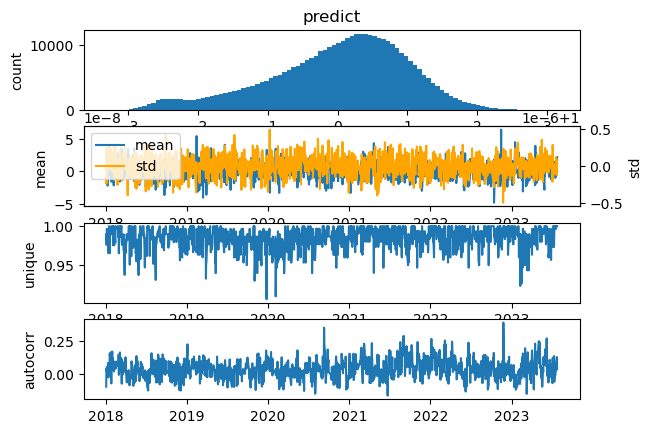

In [6]:
# 拟合模型
from scutquant import models


#model = models.MLP(input_shape=len(X_train.columns), hidden_shape=50)
model = models.CNN(input_channels=len(X_train.columns), hidden_channels=50, output_channels=20)
#model = models.GRU(input_shape=len(X_train.columns), hidden_shape=50)
model.fit(X_train, y_train, X_valid, y_valid)
pred = model.predict_pandas(X_test).to_frame(name="predict")

# model.save()

pred["predict"] = alpha.cs_zscore(alpha.mad_winsor(pred["predict"]))

report.single_factor_ana(pred["predict"])

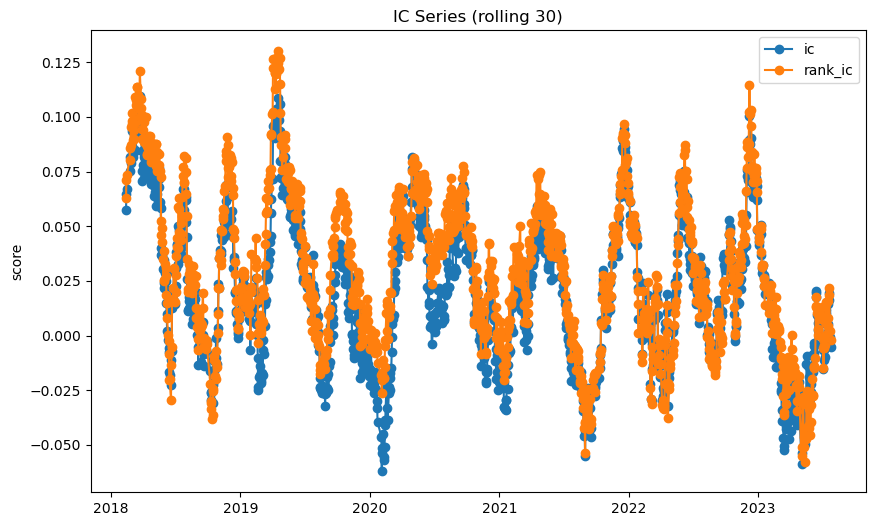

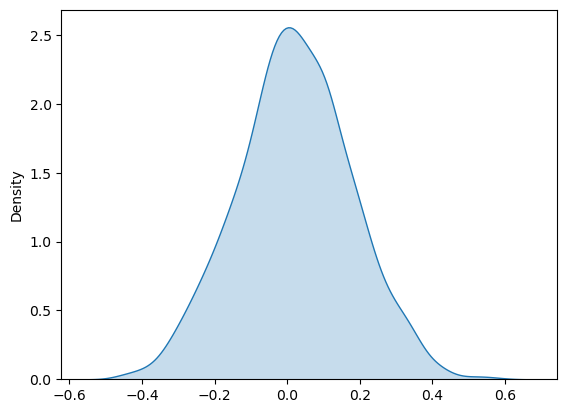

ic= 0.019668190872031588 icir= 0.12499559191328302 rank_ic= 0.02890138458760829 rank_icir= 0.17758599000873718


In [7]:
df_test = df[df.index.isin(pred.index)]
target = df_test["label"]  # 真实收益率
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, target, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)

In [8]:
# 以下为回测部分
# 将预测值处理成回测需要的格式(需要知道预测值"predict", 交易价格price和交易量volume), 注意因为是第二天才开仓, 所以price做了shift(-1)
pred = executor.prepare(pred, df_test, price='close', volume='volume', real_ret=target)

Accuracy of Prediction: 0.5301391382405745


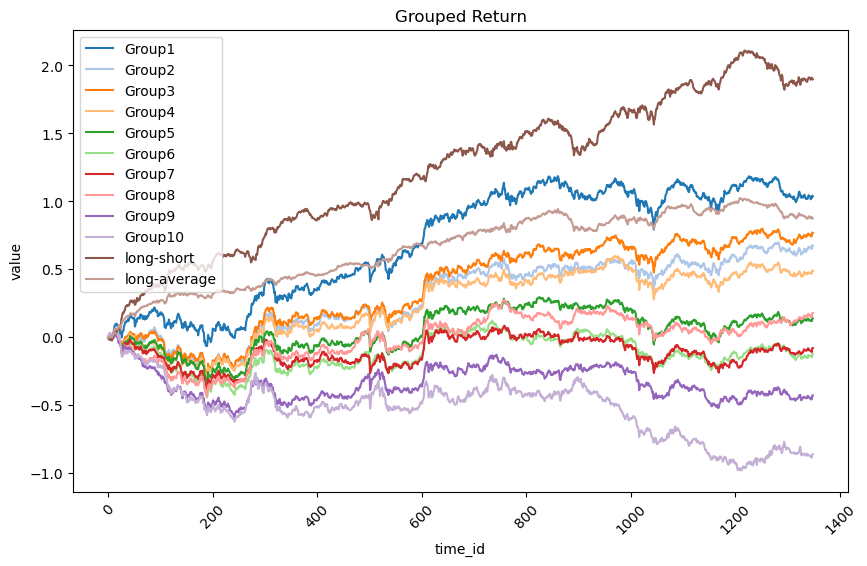

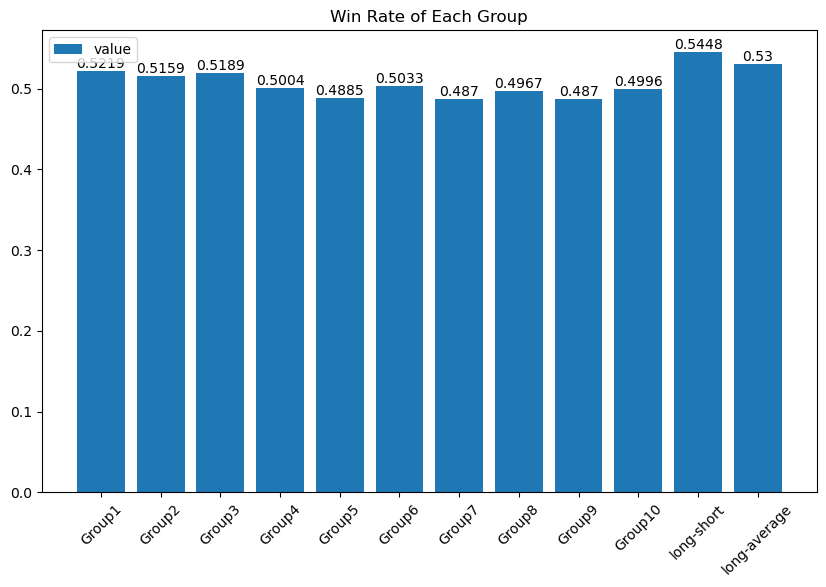

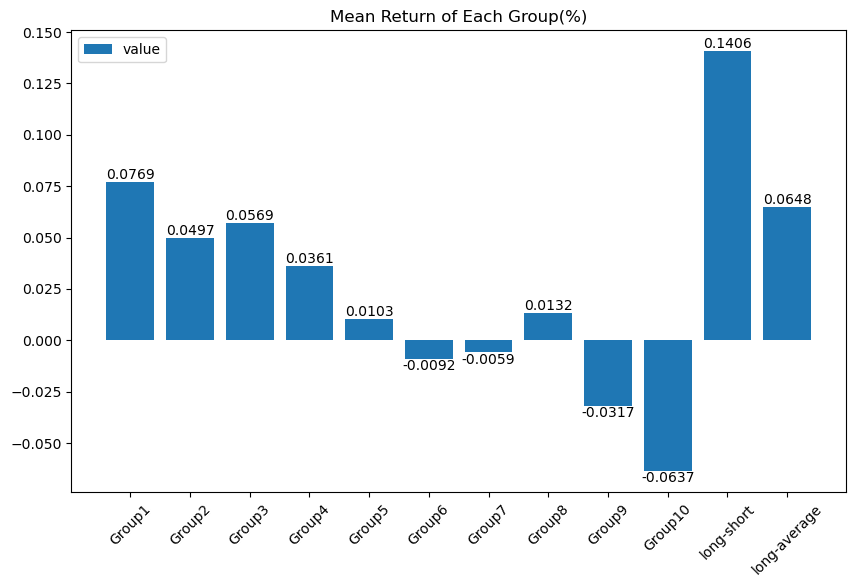

In [9]:
# 如果出现明显的分层, 则说明因子有良好的选股能力
report.group_return_ana(pred, target)

In [16]:
backtest = {
    "strategy": {
        "class": "QlibTopKStrategy",  # 做多预测值前k*100%的股票, 做空后k*100%的股票.
        "kwargs": {
            "n_start": 50, 
            "k": 0.1,
            "equal_weight": True  # qlib选择等权持有,但某些情况下加权比等权收益更好 
        }
    },
    "account": {
        "cash": 2e8,  # 初始资金
    }, 
    "trade_params": {
        "cost_buy": 0.0005,
        "cost_sell": 0.0015,  
        "min_cost": 5,
    }
}
strategy, account, trade_params = backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(strategy, account, trade_params)
exe.execute(data=pred, verbose=0)  # verbose=1时，按时间输出买卖指令

Annualized Return: 0.030985520187818194
Annualized Volatility: 0.09452181032600429
Annualized Return(Benchmark): 0.009722389827268252
Annualized Volatility(Benchmark): 0.05828843056732024 

Cumulative Rate of Return: 0.17759482460382436
Cumulative Rate of Return(Benchmark): 0.05319949466259444
Cumulative Excess Rate of Return: 0.12439532994122993 

Max Drawdown: -0.2791417402177416
Max Drawdown(Benchmark): -0.34684122866726913
Max Drawdown(Excess Return): -0.21269652190945246 

Sharpe Ratio: 1.0297971376459172
Sortino Ratio: 35.54978223793081
Information Ratio: 2.2991900314764395 

Beta: 1.530536853217593
Alpha: 0.23841539410382018
Epsilon: 0.07228982651522134
Profitable Days(%): 0.9933283914010378


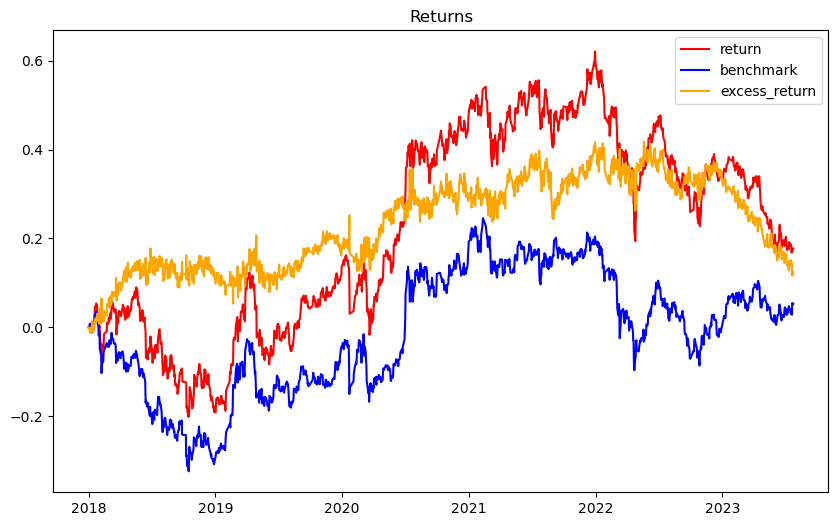

<Figure size 640x480 with 0 Axes>

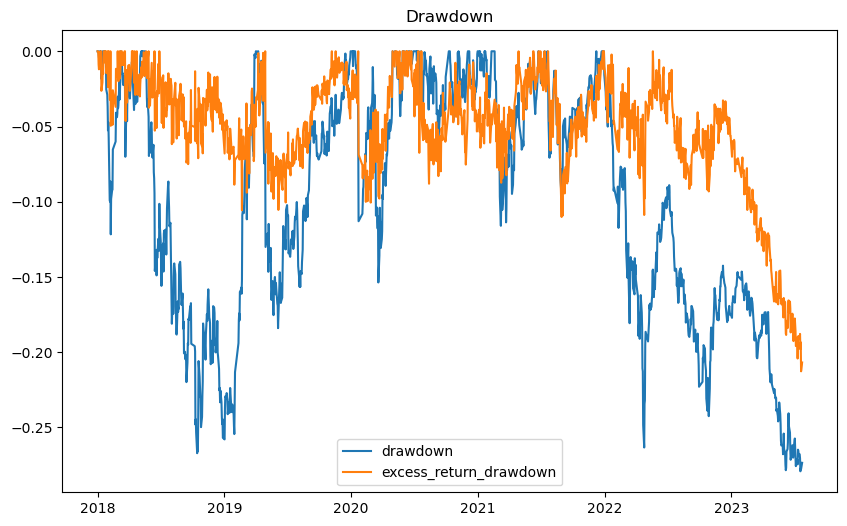

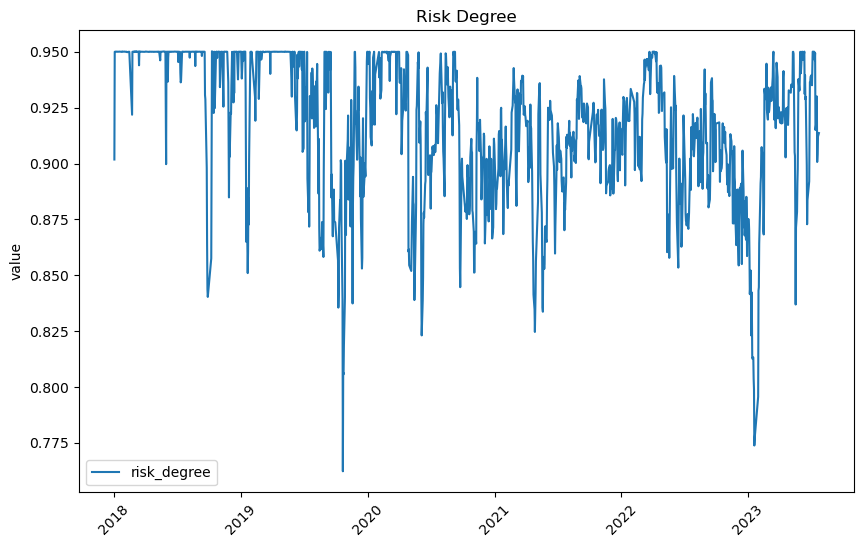

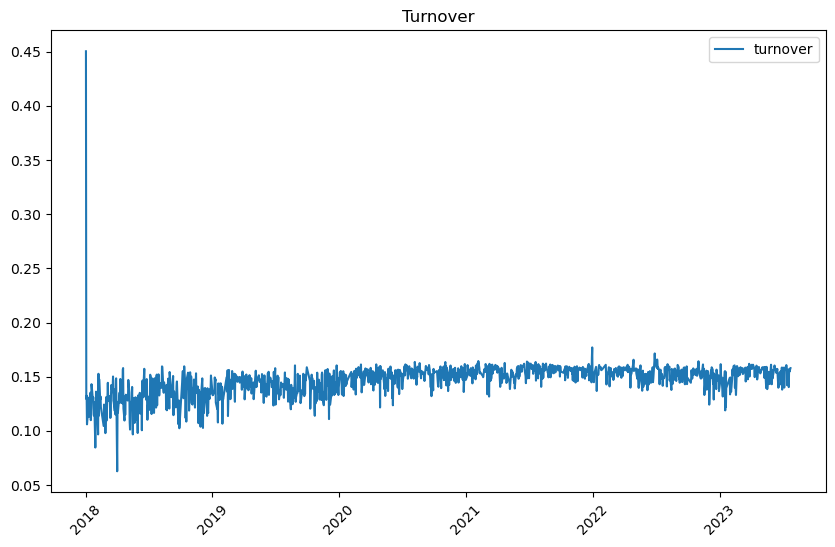

In [17]:
# 报告回测结果
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=1, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [18]:
# user_account.position